In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/VK")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

import lightgbm as lgb

from scipy.spatial import distance

from tabulate import tabulate
from tqdm import tqdm

sns.set_theme()

In [ ]:
df = pd.read_csv('intern_task.csv')

Задача:

+ подготовить и проверить датасет.
+ натренировать на любом удобном фреймворке модель, которая будет ранжировать документы по их фичам внутри одной сессии (queri_id) ( по вектору фичей предсказывать ранк документа).
+ посчитать метрики ранжирования для своей модели (ndcg_5 как минимум).
+ оформить решение и выложить на github, gitlab.

In [ ]:
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,2,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001350,0.000002,3.0,1.500000
235254,2,29995,1.0,0.0,1.0,0.0,1.0,0.500000,0.0,0.500000,...,0.0,0.000000,0.000000,0.471409,39.908056,0.000000,0.004850,0.000014,9.0,4.500000
235255,1,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001064,0.000001,1.0,0.500000
235256,2,29995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


# Функции

Ниже представлены функции, которые пригодяться для решения задачи

In [ ]:
def drop_count(df):
  """
  Выводит таблицу вида
  Имя столбца | Кол-во пропущенных значений | % пропущенных значений | тип данных
  """
  cols_with_missing = [col for col in df.columns
                    if df[col].isnull().any()]

  col_null_count = []
  for col in cols_with_missing:
      null_count = df[col].isnull().sum()
      col_null_count.append([
          col,
          null_count,
          round(null_count / len(df[col]), 2),
          df[col].dtype
      ])

  col_null_count.sort(key=lambda x: x[1])

  return col_null_count

In [ ]:
def ndcg(y_score, y_true, k):
  """
  Подсчет ndcg для массива y_score и y_true с параметром k
  """
  order = np.argsort(y_score)[::-1]
  y_true = np.take(y_true, order[:k])

  gain = 2 ** y_true - 1

  discounts = np.log2(np.arange(len(y_true)) + 2)
  return np.sum(gain / discounts)

def total_ndcg(k, model):
  """
  Подсчет усредненного значения ndcg для всех запросов
  """
  ndcg_ = list()

  qid_test = df_test["query_id"].unique()

  for i, qid in enumerate(qid_test):
      y = y_test[df_test["query_id"] == qid]

      if np.sum(y) == 0:
          continue

      p = model.predict(X_test[df_test["query_id"] == qid])

      idcg = ndcg(y, y, k)
      ndcg_.append(ndcg(p, y, k) / idcg)

  return np.mean(ndcg_)

Функция `print_col_info`, которая ниже, выводит краткую информацию по данным для каждого столбца. Выводит в формате:

| Имя столбца | Кол-во уникальных элементов | 10 элементов | список типов, которые присутсвуют в столбце |
| -- | -- | -- | -- |

Таблица выводиться в сортированном виде по кол-ву уникальных элементов в столбце.

In [ ]:
def print_col_info(df):
  """
  Вывод первичных сведений по каждому столбцу
  """
  uniq_col_count = []
  for col in df:
      uniq_count = df[col].unique()
      types = set([type(x) for x in uniq_count])
      uniq_col_count.append([col, len(uniq_count), uniq_count[:10], types])

  uniq_col_count.sort(key=lambda x: x[1])

  print(tabulate(uniq_col_count, headers=['Col', 'Uniq_num', 'Values (top 10)', 'Types']))

# Анализ данных

Проверим на наличие пропущенных значений и выведим краткую информацию

In [ ]:
col_null_count = drop_count(df)
print(tabulate(col_null_count, headers=['Col', 'Null Count', 'Null %', 'Type']))

Col    Null Count    Null %    Type
-----  ------------  --------  ------


In [ ]:
print_col_info(df)

Col            Uniq_num  Values (top 10)                                                           Types
-----------  ----------  ------------------------------------------------------------------------  -------------------------
feature_64            1  [0]                                                                       {<class 'numpy.int64'>}
feature_65            1  [0]                                                                       {<class 'numpy.int64'>}
feature_72            1  [1]                                                                       {<class 'numpy.int64'>}
feature_100           1  [0]                                                                       {<class 'numpy.int64'>}
feature_95            2  [0. 1.]                                                                   {<class 'numpy.float64'>}
feature_96            2  [0. 1.]                                                                   {<class 'numpy.float64'>}
feature_97            2  [0.

Можно заметить, что фичи `feature_64`, `feature_65`, `feature_72` и `feature_100` имеют всего одно уникальное значение, поэтому их можно удалить

In [ ]:
df = df.drop(columns=['feature_64', 'feature_65', 'feature_72', 'feature_100'], axis=1)

построим матрицу корреляций для поиска малоинформативных фичей

<Axes: >

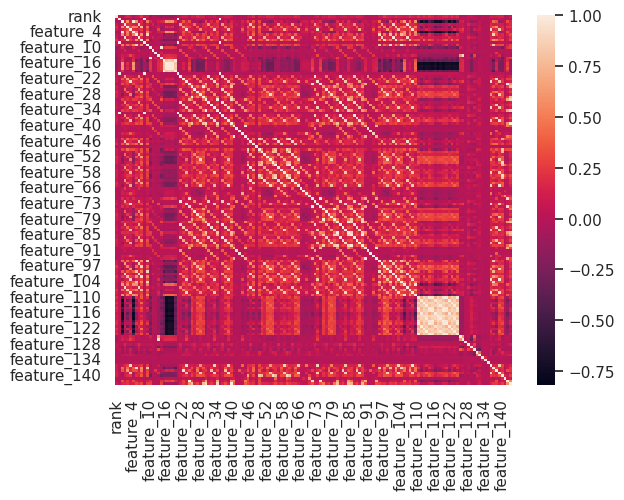

In [ ]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)

Из-за большой размерности плохо видно значения, но по тепловой карте четко видно, что некоторые параметры сильно коррелируют друг с другом. Найдем те, у которых коеффициент корреляяции больше 0,99 с целью уменьшить размерность пространства.

In [ ]:
hight_corr = [(i, j) for i in range(2, corr_matrix.shape[0]) for j in range(i, corr_matrix.shape[1]) if corr_matrix.iloc[i, j] > 0.99 and i != j]
len(hight_corr)

23

<Axes: >

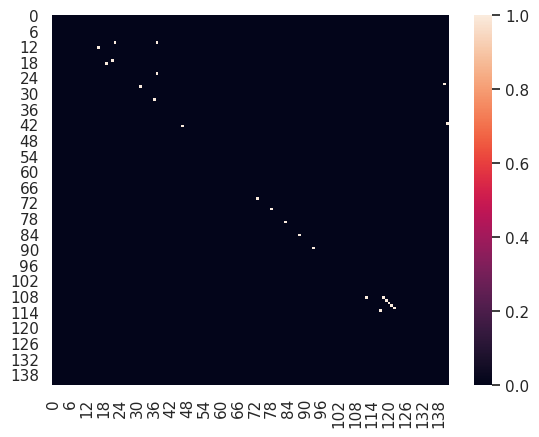

In [ ]:
corr_mask = np.zeros(corr_matrix.shape)
for i, j in hight_corr:
  corr_mask[i][j] = 1
sns.heatmap(corr_mask)

In [ ]:
cols_indx_for_drop = [df.columns[i[0]] for i in hight_corr]
df = df.drop(columns=cols_indx_for_drop, axis=1)
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,2,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001350,0.000002,3.0,1.500000
235254,2,29995,1.0,0.0,1.0,0.0,1.0,0.500000,0.0,0.500000,...,0.0,0.000000,0.000000,0.471409,39.908056,0.000000,0.004850,0.000014,9.0,4.500000
235255,1,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001064,0.000001,1.0,0.500000
235256,2,29995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


# Подготовка данных для обучения

Разделение на тренировочную и тестовую выборку делаем на `query_id`, чтобы документы из одного запроса не попали в разные выборки.

In [ ]:
query_train, query_test = train_test_split(df['query_id'].unique(), test_size=.2, random_state=4)

In [ ]:
print(f"No of unique queries in train : {query_train.shape}")
print(f"No of unique queries in train : {query_test.shape}")

No of unique queries in train : (1600,)
No of unique queries in train : (400,)


In [ ]:
df_train = df[df['query_id'].isin(query_train)]
df_test = df[df['query_id'].isin(query_test)]

print(f"No of unique queries in train : {df_train.shape}")
print(f"No of unique queries in train : {df_test.shape}")

No of unique queries in train : (187245, 121)
No of unique queries in train : (48013, 121)


In [ ]:
qids_train = df_train.groupby("query_id")["query_id"].count().to_numpy()
X_train = df_train.drop(["query_id", "rank"], axis = 1)
y_train = df_train['rank'].astype(int)

qids_test = df_test.groupby("query_id")["query_id"].count().to_numpy()
X_test = df_test.drop(["query_id", "rank"], axis = 1)
y_test = df_test['rank'].astype(int)

# Первичное обучение

В качестве модели я выбрал **LGBMRanker**. Так же проверил модели **CatBoostRanker** и **XGBRanker**, но их результат оказался хуже.

In [ ]:
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric="ndcg",
    n_estimators=1000,
    random_state=4
)

gbm = ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      callbacks=[lgb.log_evaluation(10), lgb.early_stopping(50)],
      eval_at=[5, 10])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21069
[LightGBM] [Info] Number of data points in the train set: 187245, number of used features: 119
Training until validation scores don't improve for 50 rounds
[10]	training's ndcg@5: 0.465134	training's ndcg@10: 0.485847	valid_1's ndcg@5: 0.421951	valid_1's ndcg@10: 0.450126
[20]	training's ndcg@5: 0.505619	training's ndcg@10: 0.518415	valid_1's ndcg@5: 0.445387	valid_1's ndcg@10: 0.471109
[30]	training's ndcg@5: 0.531211	training's ndcg@10: 0.541213	valid_1's ndcg@5: 0.470214	valid_1's ndcg@10: 0.488845
[40]	training's ndcg@5: 0.549283	training's ndcg@10: 0.555225	valid_1's ndcg@5: 0.481235	valid_1's ndcg@10: 0.495513
[50]	training's ndcg@5: 0.56438	training's ndcg@10: 0.568376	valid_1's ndcg@5: 0.484962	valid_1's ndcg@10: 0.498941

Рассчитаем метрику NDCG5 и NDCG10

In [ ]:
total_ndcg(5, gbm), total_ndcg(10, gbm)

(0.47204551236958364, 0.49083045191762475)

# Тюнинг модели

## Отброс малоинформативных фич

Первым делом посмотрим, какие фичи оказали наименьшение влияние. Удалим их и посмотрим на результат.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

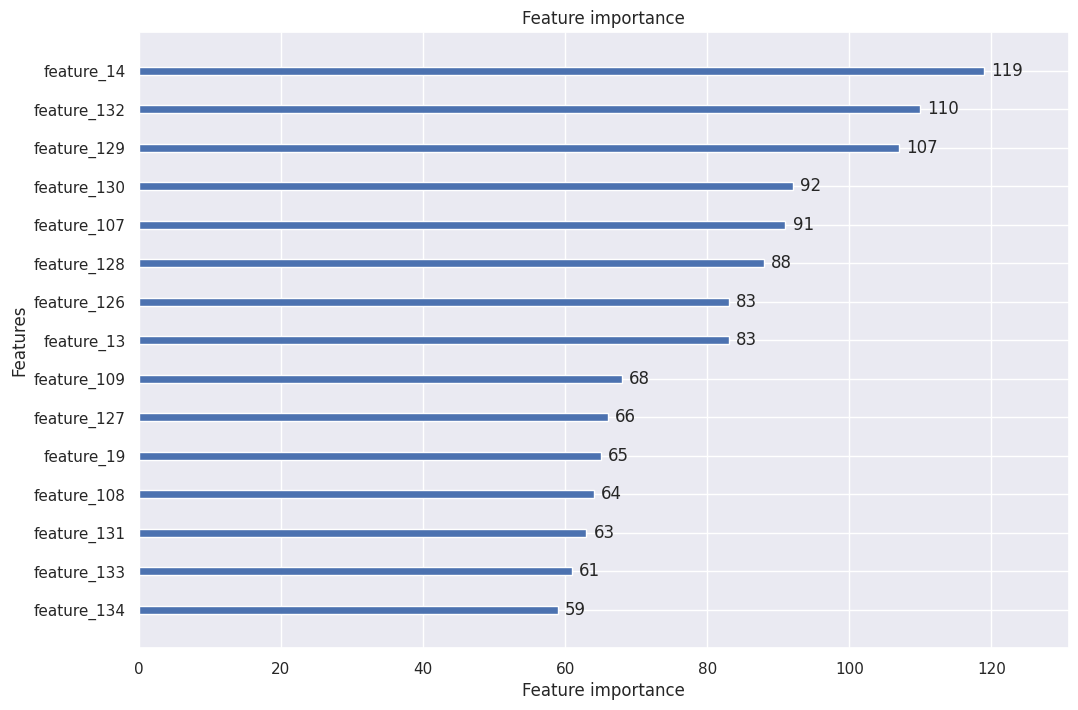

In [ ]:
lgb.plot_importance(gbm, figsize = (12,8), max_num_features=15)

In [ ]:
ranker.feature_importances_

array([  5,   3,  18,   2,   1,  11,   4,   3,  11,  16,  34,  83, 119,
        29,  33,  65,   5,   5,   2,   0,   0,   1,  31,   0,   0,   0,
        13,  34,   1,   6,   0,   3,   5,   1,  26,  17,   5,  22,  31,
        50,  14,   8,   3,   4,  39,  12,   2,  16,   9,  27,  15,   0,
        11,   3,   4,  12,   9,  14,  11,  17,  25,   3,   5,   6,  24,
         1,  13,  23,  23,   6,  11,  15,  17,   2,  23,  18,  25,   0,
         0,   0,   0,   0,   1,  10,  11,  20,  29,  18,  91,  64,  68,
        51,  17,  23,  21,  17,  41,  57,  32,  33,  41,  83,  66,  88,
       107,  92,  63, 110,  61,  59,  55,  18,  29,  36,   1,  38,  29,
        28,  17], dtype=int32)

In [ ]:
coumns_with_lower_importances = []
for i in range(len(ranker.feature_importances_)):
  if ranker.feature_importances_[i] == 0:
    coumns_with_lower_importances.append(df.columns[i])

In [ ]:
df = df.drop(columns=coumns_with_lower_importances, axis=1)

df_train = df[df['query_id'].isin(query_train)]
df_test = df[df['query_id'].isin(query_test)]

print(f"No of unique queries in train : {df_train.shape}")
print(f"No of unique queries in train : {df_test.shape}")

qids_train = df_train.groupby("query_id")["query_id"].count().to_numpy()
X_train = df_train.drop(["query_id", "rank"], axis = 1)
y_train = df_train['rank'].astype(int)

qids_test = df_test.groupby("query_id")["query_id"].count().to_numpy()
X_test = df_test.drop(["query_id", "rank"], axis = 1)
y_test = df_test['rank'].astype(int)

No of unique queries in train : (187245, 109)
No of unique queries in train : (48013, 109)


In [ ]:
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric="ndcg",
    n_estimators=1000,
    random_state=4,
    n_jobs=2
)

gbm = ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      callbacks=[lgb.log_evaluation(10), lgb.early_stopping(50)],
      eval_at=[5, 10])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19970
[LightGBM] [Info] Number of data points in the train set: 187245, number of used features: 107
Training until validation scores don't improve for 50 rounds
[10]	training's ndcg@5: 0.46897	training's ndcg@10: 0.485931	valid_1's ndcg@5: 0.423688	valid_1's ndcg@10: 0.449797
[20]	training's ndcg@5: 0.504523	training's ndcg@10: 0.518503	valid_1's ndcg@5: 0.445067	valid_1's ndcg@10: 0.468833
[30]	training's ndcg@5: 0.528846	training's ndcg@10: 0.53985	valid_1's ndcg@5: 0.468401	valid_1's ndcg@10: 0.486127
[40]	training's ndcg@5: 0.549429	training's ndcg@10: 0.556065	valid_1's ndcg@5: 0.475461	valid_1's ndcg@10: 0.493321
[50]	training's ndcg@5: 0.565646	training's ndcg@10: 0.568751	valid_1's ndcg@5: 0.476722	valid_1's ndcg@10: 0.496818


In [ ]:
total_ndcg(5, gbm), total_ndcg(10, gbm)

(0.47382272937973896, 0.4898841972053191)

У метрики NDCG5 результат улучшился на `0,001777217`, а у NDCG10 ухудшился на `0,000946255`. Двигаемся дальше)

## Подбор параметров

К сожалению api sklearn не поддерживает модель для ранжирования LGBMRanker, поэтому поиск параметров при дется делать вручную.

In [ ]:
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': 2,
 'num_leaves': 31,
 'objective': 'lambdarank',
 'random_state': 4,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'ndcg'}

In [ ]:
def tune_lgbm_ranker(X_train, y_train, X_val, y_val, qids_train, qids_test, param_grid):
    best_score_ngcg5 = 0
    best_score_ngcg10 = 0
    best_params = {
        'ngcg5': {},
        'ngcg10': {},
    }

    for min_child_samples in param_grid['min_child_samples']:
        for num_leaves in param_grid['num_leaves']:
            for learning_rate in param_grid['learning_rate']:
                params = {
                    'min_child_samples': min_child_samples,
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate
                }

                model = lgb.LGBMRanker(**params, metric="ndcg", objective='lambdarank', n_estimators=1000, random_state=4, n_jobs=2, verbose=0)
                model.fit(
                    X=X_train,
                    y=y_train,
                    group=qids_train,
                    eval_set=[(X_train, y_train),(X_val, y_val)],
                    eval_group=[qids_train, qids_test],
                    callbacks=[lgb.early_stopping(50)],
                    eval_at=[5, 10]
                )
                y_pred = model.predict(X_val)

                ngcg5_score = total_ndcg(5, model)
                ngcg10_score = total_ndcg(10, model)

                if best_score_ngcg5 < ngcg5_score:
                    best_score_ngcg5 = ngcg5_score
                    best_params['ngcg5'] = params

                if best_score_ngcg10 < ngcg10_score:
                    best_score_ngcg10 = ngcg10_score
                    best_params['ngcg10'] = params

                print(params)
                print(f'ngcg5_score = {ngcg5_score}, ngcg10_score = {ngcg10_score}')
                print('-------\n')

    return best_params, best_score_ngcg5, best_score_ngcg10

In [ ]:
param_grid = {
    'min_child_samples': [10, 20, 30],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
}

best_params, best_score_ngcg5, best_score_ngcg10 = tune_lgbm_ranker(X_train, y_train, X_test, y_test, qids_train, qids_test, param_grid)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	training's ndcg@5: 0.564236	training's ndcg@10: 0.568533	valid_1's ndcg@5: 0.485474	valid_1's ndcg@10: 0.502842
{'min_child_samples': 10, 'num_leaves': 20, 'learning_rate': 0.05}
ngcg5_score = 0.46939223045771616, ngcg10_score = 0.4873209883258382
-------

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	training's ndcg@5: 0.586113	training's ndcg@10: 0.585497	valid_1's ndcg@5: 0.492338	valid_1's ndcg@10: 0.504417
{'min_child_samples': 10, 'num_leaves': 20, 'learning_rate': 0.1}
ngcg5_score = 0.47662040732672917, ngcg10_score = 0.48910335968401936
-------

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	training's ndcg@5: 0.616722	training's ndcg@10: 0.613301	valid_1's ndcg@5: 0.487958	valid_1's ndcg@10: 0.496644
{'min_child_samples': 10, 'num_leaves': 20, 'learning_rate': 0.2}
ngc

In [ ]:
best_score_ngcg5, best_score_ngcg10

(0.47946931191747055, 0.497103622872247)

In [ ]:
best_params

{'ngcg5': {'min_child_samples': 30, 'num_leaves': 30, 'learning_rate': 0.05},
 'ngcg10': {'min_child_samples': 30, 'num_leaves': 30, 'learning_rate': 0.05}}

Обучим модель на найденных параметрах.

In [ ]:
# Creating the ranker object
model = lgb.LGBMRanker(
    objective='lambdarank',
    metric="ndcg",
    n_estimators=1000,
    min_child_samples=30,
    num_leaves=30,
    learning_rate=0.05,
    n_jobs=2,
    random_state=4
)

# Training the model
gbm = model.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      callbacks=[lgb.log_evaluation(10), lgb.early_stopping(50)],
      eval_at=[5, 10])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.275234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19970
[LightGBM] [Info] Number of data points in the train set: 187245, number of used features: 107
Training until validation scores don't improve for 50 rounds
[10]	training's ndcg@5: 0.450572	training's ndcg@10: 0.470013	valid_1's ndcg@5: 0.421393	valid_1's ndcg@10: 0.444268
[20]	training's ndcg@5: 0.47249	training's ndcg@10: 0.492586	valid_1's ndcg@5: 0.432682	valid_1's ndcg@10: 0.455272
[30]	training's ndcg@5: 0.491416	training's ndcg@10: 0.507281	valid_1's ndcg@5: 0.442354	valid_1's ndcg@10: 0.463199
[40]	training's ndcg@5: 0.50758	training's ndcg@10: 0.521008	valid_1's ndcg@5: 0.456	valid_1's ndcg@10: 0.474598
[50]	training's ndcg@5: 0.520446	training's ndcg@10: 0.53207	valid_1's ndcg@5: 0.466211	valid_1's ndcg@10: 0.484738
[60]

In [ ]:
total_ndcg(5, gbm), total_ndcg(10, gbm)

(0.47946931191747055, 0.497103622872247)

Относительно изначального результата у метрики NDCG5 результат улучшился на `0,005646583`, а у NDCG10 улучшился на `0,006273171`. Отлично!

## Ансабль

Еще одно из решений повысить точность это использовать ансабль моделей. Тк данных не много, то добавим еще 2 модели к нашей текущей.

In [ ]:
kf = KFold(n_splits=2)

X_train_folds = []
y_train_folds = []
group_train_folds = []

X_test_folds = []
y_test_folds = []
group_test_folds = []

for i, (train_qids_index, test_qids_index) in enumerate(kf.split(query_train)):
  df_train_fold = df[df['query_id'].isin(np.take(query_train, train_qids_index))]
  df_test_fold = df[df['query_id'].isin(np.take(query_train, test_qids_index))]

  print(f"No of unique queries in train (fold {i}): {df_train_fold.shape}")
  print(f"No of unique queries in test (fold {i}): {df_test_fold.shape}")

  group_train_folds.append(df_train_fold.groupby("query_id")["query_id"].count().to_numpy())
  group_test_folds.append(df_test_fold.groupby("query_id")["query_id"].count().to_numpy())

  X_train_folds.append(df_train_fold.drop(["query_id", "rank"], axis = 1))
  y_train_folds.append(df_train_fold['rank'].astype(int))

  X_test_folds.append(df_test_fold.drop(["query_id", "rank"], axis = 1))
  y_test_folds.append(df_test_fold['rank'].astype(int))

No of unique queries in train (fold 0): (92151, 109)
No of unique queries in test (fold 0): (95094, 109)
No of unique queries in train (fold 1): (95094, 109)
No of unique queries in test (fold 1): (92151, 109)


In [ ]:
models = []

for i in range(2):
  model = lgb.LGBMRanker(
    objective='lambdarank',
    metric="ndcg",
    n_estimators=1000,
    min_child_samples=30,
    num_leaves=30,
    learning_rate=0.05,
    n_jobs=2,
    random_state=4,
    verbose=0
  )

  model.fit(
      X=X_train_folds[i],
      y=y_train_folds[i],
      group=group_train_folds[i],
      eval_set=[(X_test_folds[i], y_test_folds[i])],
      eval_group=[group_test_folds[i]],
      callbacks=[lgb.early_stopping(50)])
  models.append(model)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's ndcg@1: 0.474726	valid_0's ndcg@2: 0.452807	valid_0's ndcg@3: 0.450875	valid_0's ndcg@4: 0.453767	valid_0's ndcg@5: 0.455795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's ndcg@1: 0.5035	valid_0's ndcg@2: 0.490223	valid_0's ndcg@3: 0.483661	valid_0's ndcg@4: 0.488112	valid_0's ndcg@5: 0.491635


In [ ]:
models.append(gbm)

In [ ]:
ndcg_5 = list()
ndcg_10 = list()

qid_test = df_test["query_id"].unique()

for i, qid in enumerate(qid_test):
  y = y_test[df_test["query_id"] == qid]

  if np.sum(y) == 0:
      continue

  p = np.empty((len(models), len(y)))
  for ind, model in enumerate(models):
    p[ind] = model.predict(X_test[df_test["query_id"] == qid])

  p = sum(p) / len(p)

  idcg5 = ndcg(y, y, 5)
  ndcg_5.append(ndcg(p, y, 5) / idcg5)

  idcg10 = ndcg(y, y, 10)
  ndcg_10.append(ndcg(p, y, 10) / idcg10)

print(f'NDCG5 = {np.mean(ndcg_5)}')
print(f'NDCG10 = {np.mean(ndcg_10)}')

NDCG5 = 0.4744209675469801
NDCG10 = 0.4911636783322146


К сожалению в ансабле результаты только ухудшились :(

# Постанализ

Проведем постанализ, чтобы составить несколько гипотез по улучшению модели.

Первым делом

In [ ]:
ndcg_metric = {
    'NDCG5': [],
    'NDCG10': [],
    'ids': []
}

qid_test = df_test["query_id"].unique()

for i, qid in enumerate(qid_test):
  y = y_test[df_test["query_id"] == qid]

  if np.sum(y) == 0:
      continue

  p = gbm.predict(X_test[df_test["query_id"] == qid])

  idcg5 = ndcg(y, y, 5)
  ndcg_metric['NDCG5'].append(ndcg(p, y, 5) / idcg5)

  idcg10 = ndcg(y, y, 10)
  ndcg_metric['NDCG10'].append(ndcg(p, y, 10) / idcg10)

  ndcg_metric['ids'].append(qid)

Text(0.5, 1.0, 'NDCG10')

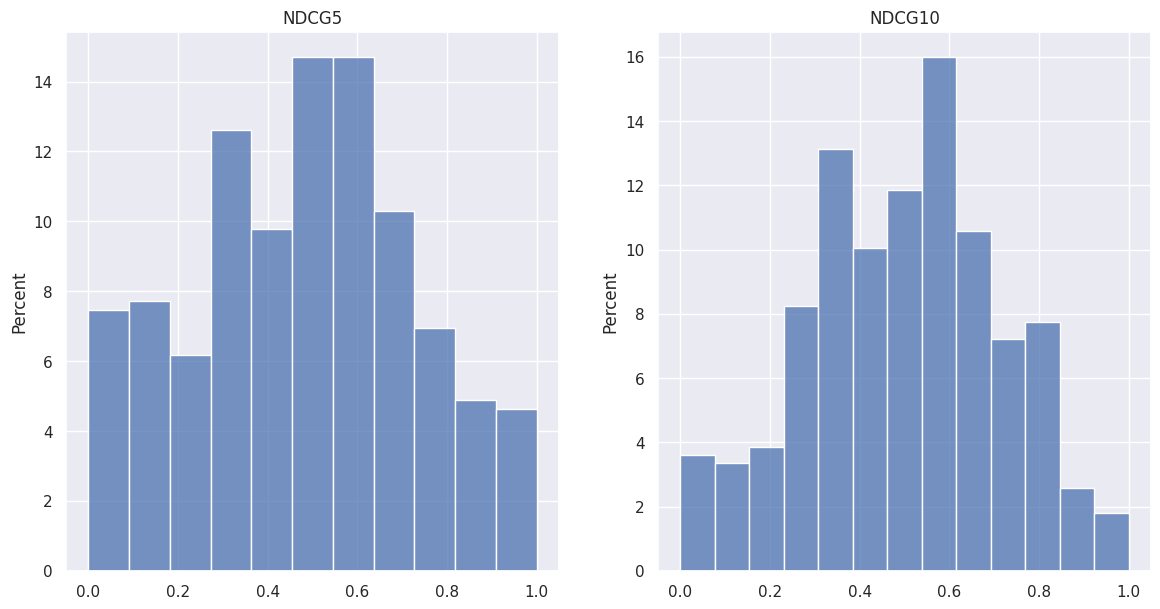

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))
sns.histplot(ndcg_metric['NDCG5'], ax=ax[0], stat='percent')
sns.histplot(ndcg_metric['NDCG10'], ax=ax[1], stat='percent')
ax[0].set_title('NDCG5')
ax[1].set_title('NDCG10')

Видно, что в большинстве случаев модель предсказывает со значением метрики от 0,4 до 0,6. Справа график близок к нормальному распределению.

Посмотрим на данные, у которых метрика равна нулю и единице.

In [ ]:
qid0 = []
qid1 = []

for i, val in enumerate(ndcg_metric['NDCG5']):
  if val < 0.05:
    qid = ndcg_metric['ids'][i]
    qid0.append(qid)
    print("0: ", qid, len(df_test[df_test["query_id"] == qid]))
  if val > 0.9:
    qid = ndcg_metric['ids'][i]
    qid1.append(qid)
    print("1: ", qid, len(df_test[df_test["query_id"] == qid]))

1:  130 84
1:  880 84
1:  970 57
1:  1060 83
0:  1150 59
0:  2830 171
1:  3205 148
1:  3505 49
1:  3880 73
0:  3925 95
0:  5590 84
1:  5620 40
0:  7780 76
1:  8170 22
0:  8245 20
0:  8920 195
0:  9925 36
1:  10060 72
0:  10405 146
0:  10615 15
1:  10900 49
1:  10915 93
0:  11110 119
0:  13795 210
1:  14605 190
0:  15115 106
1:  16690 84
0:  17020 11
1:  17770 194
1:  17920 7
0:  19075 60
0:  19090 14
0:  19405 30
1:  22345 89
1:  22780 2
1:  23170 80
1:  25525 28
0:  26335 102
0:  28420 187


In [ ]:
len(qid0), len(qid1)

(19, 20)

При помощи describe посмотрим краткую характеристику по данным и найдем различия с помощью косинусного сходства двух списков.

In [ ]:
qid0_desc = df_test[df_test["query_id"].isin(qid0)].describe().T
qid1_desc = df_test[df_test["query_id"].isin(qid1)].describe().T

In [ ]:
for i in range(2, len(qid0_desc)):
  var0 = qid0_desc[['mean', 'std', '25%', '50%', '75%']].iloc[i:i+1, :]
  var1 = qid1_desc[['mean', 'std', '25%', '50%', '75%']].iloc[i:i+1, :]
  cos_dist = distance.cosine(var0.values.reshape(1, -1)[0], var1.values.reshape(1, -1)[0])
  cos_sim = 1 - cos_dist  # Получаем косинусную меру сходства
  if cos_sim < 0.9:
    print(f'Cos of col {qid0_desc.index[i]} is {cos_sim}')

Cos of col feature_2 is 0.8897701870673029
Cos of col feature_5 is 0.8874966608406742
Cos of col feature_9 is 0.8867459219521647
Cos of col feature_12 is 0.6421152391859466
Cos of col feature_27 is 0.585163730447212
Cos of col feature_32 is 0.8953966609362617
Cos of col feature_43 is 0.6381620166634775
Cos of col feature_52 is 0.7498727291133687
Cos of col feature_54 is 0.863818338056315
Cos of col feature_68 is 0.7990477663186512
Cos of col feature_77 is 0.652319766093656
Cos of col feature_79 is 0.8803050000887421
Cos of col feature_99 is 0.7649039639673916
Cos of col feature_102 is 0.8804274839778259
Cos of col feature_104 is 0.8923633960585242


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


# Выводы и что можно сделать дальше

## Выводы

Итоговый результат для метрик NDCG5 и NDCG10 составили 0.479 и 0.497 соответсвенно. Лучшая модель оказалась LGBMRanker с параметрами

```python
objective='lambdarank',
min_child_samples=30,
num_leaves=30,
learning_rate=0.05
```

Фичи, которые внесли ключевой вклад это **feature_14**, **feature_132** и **feature_129**. В тоже время **feature_77**, **feature_43**, **feature_12** показали наибольшее различие среди запросов, по которым модель смогла поставить ранг документам правильно и которым не смогла.

## Что можно сделать дальше?

Если бы у меня было больше времени, я бы посмотрел следующие стратегии.

1. **Добавить новые фичи.** Главное перпятствие это то, что я не знаю что это за фичи. Можно бездумно перемножать или складывать, то это равносильно тыкнуть пальцем в небо. Если будет описание, то можно думать над различной агрегацией и тем самым дать модели новые данные.
2. **Более подробно иучить фичи.** Интересно разузнать почему характеристики feature_77, feature_43, feature_12 сильно отличаются в зависимости от ответа модели.
2. **Кластелизировать документы.** С помощью алгоритмов кластеризации разделить документы на подгруппы. Возможно это так же повысит информативность.
3. **Создать несколько моделей на разные подгруппы запросов.** Разделить запросы по какому-нибудь признаку и обучить под каждый тип запроса отдельную модель. За счет этого у каждой моедли будет более "специализированные" запросы, за счет чего качество каждой повысится. И как следствие общий результат тоже.
4. **Попробовать нейронные сети.** Скорее всего нейронные сети тут излишние (и скорее всего это так), но попробовать стоит.

На этом всё. Задачка была необычная и интересная)